# Assignment 7

## About

This week is all about Grover's Algorithm. 

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
import math

##### 1. Grover's Algorithm attempts to find some target state $\ket{m}$ by repeatedly applying reflections $R_b$ and $R_s$ on the initial state $\ket{s}$, where $\ket{s}$ is a superposition of all the basis states in the computational basis. Implement a function *initialize_s(n)* which returns a QuantumCircuit which sets the state to $\ket{s}$ for $n$ qubits.

In [2]:
def initialize_s(n) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.x(i)
    return qc

We will now try to run Grover's Algorithm for your choice of target state $\ket{m}$ and a variable number of qubits $n$. 

NB: For Grover's Algorithm to work in practice, we technically need an auxiliary qubit in the state $\ket{-}$ to provoke the necessary phase kickback. However, we will ignore the auxiliary qubit in the exercises below for demonstration purposes. 

In [3]:
n = 4
m = 15

Firstly, we will need the reflection operators $R_b$ and $R_s$.

##### 2. Implement a function *Z_f(n, m)* which returns a UnitaryGate representing a reflection around the bad state $\ket{b}$ for $n$ qubits and for some choice of target $m$.

In [4]:
def Z_f(n, m) -> UnitaryGate:
    matrix = np.eye(2**n)
    matrix[m,m] = -1
    return UnitaryGate(matrix, label="Z_f")

##### 3. Implement a function *Z_or(n)*, which represents a phase_shift to the input if it is in $\ket{0}$, and otherwise does nothing. 

In [5]:
def Z_or(n) -> UnitaryGate:
    matrix = np.eye(2**n)
    matrix[0,0] = -1
    return UnitaryGate(matrix, label="Z_or")

##### 4. Implement a function *D(n)* which returns the diffusion operator using $Z_{\text{or}}$ as a gate.

In [6]:
def D(n) -> UnitaryGate:
    H = (1/np.sqrt(2))*np.array([[1, 1],
                               [1, -1]])
    H_n = np.kron(H,H)
    for _ in range(n-2):         
        H_n = np.kron(H_n, H)
    z_or = np.eye(2**n)
    z_or[0,0] = -1
    matrix = H_n@z_or@H_n
    return UnitaryGate(matrix, label="D")

You now have all the necessary pieces to execute Grover's Algorithm!

##### 5. Implement Grover's Algorithm using the gates you've constructed in the previous tasks. 

In [7]:
def grover(n, m) -> QuantumCircuit:
    steps = np.round((np.pi/4)*np.sqrt(2**n)-1/2)

    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)

    qc.append(Z_f(n,m), range(n))
    qc.append(D(n), range(n))

    return qc

##### 6. Run Grover's Algorithm for 1000 shots and plot the result as a histogram. Do you sucessfully retrieve $m$?

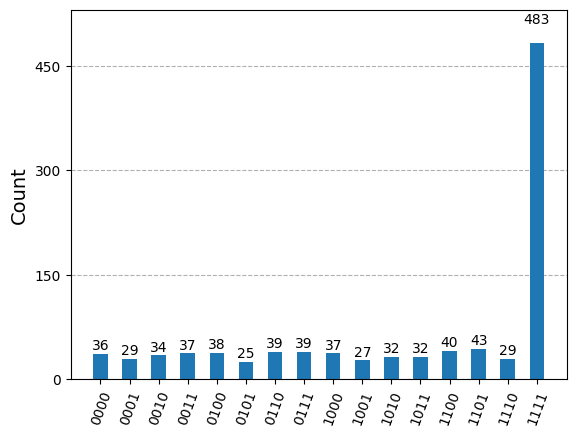

In [8]:
backend = AerSimulator()

circuit = grover(n, m)
# qc.measure(range(1, n_bits+1), range(n_bits))
circuit.measure_all()
t_qc = transpile(circuit, backend) # To save you some time debugging, you will likely need to transpile your QuantumCircuit in order to run it.
job = backend.run(t_qc, shots=1000)
result = job.result()
plot_histogram(result.get_counts())

##### 8. In the above task we used the knowledge of what $m$ is in order to construct the gates needed to run Grover's Algorithm, which might seemingly defeat the purpose. However, we do not actually need $m$! Explain how and why this is the case. 

We use phasekickback and get the sign to create the matrices.

##### 7. Implement a new function *Z_f_list(n, list_m)* which takes in a list of targets, and returns the corresponding gate.

In [9]:
def Z_f_list(n, m_list) -> UnitaryGate:
    matrix = np.eye(2**n)
    for i in m_list:
        matrix[i,i] = -1
    return UnitaryGate(matrix, label="Z_f_list")

#### 8. Rerun Grover's Algorithm using a list of target values and plot the result. How does having multiple "correct" values affect the measurement distribution?

In [10]:
m_list = [0, 2]

def grover_list(n, m_list) -> QuantumCircuit:
    steps = np.round((np.pi/4)*np.sqrt(2**n)-1/2)

    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)

    qc.append(Z_f_list(n,m_list), range(n))
    qc.append(D(n), range(n))

    return qc

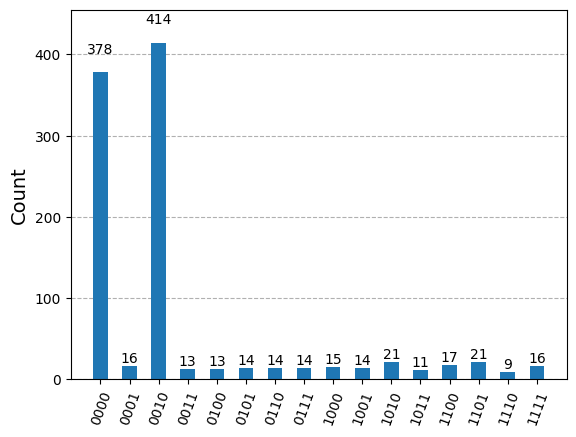

In [11]:
circuit = grover_list(n, m_list)
circuit.measure_all()
t_qc = transpile(circuit, backend)
job = backend.run(t_qc, shots=1000)
result = job.result()
plot_histogram(result.get_counts())